# Student Enrollment Status Prediction

A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. The dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. The task is to predict the enrollment status at the end of the normal duration of the course, i.e, dropout, enrolled, or graduate. The classes are coded as 0,1 and 2 in the dataset.

## Set up

Importing essential libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import GenericUnivariateSelect, SelectKBest, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, validation_curve
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline

## Loading data

In [4]:
train = pd.read_csv("data.csv")

## Exploratory Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3796 entries, 0 to 3795
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3796 non-null   int64  
 1   v_21    3796 non-null   int64  
 2   v_32    3796 non-null   int64  
 3   v_15    3796 non-null   int64  
 4   v_4     3796 non-null   int64  
 5   v_1     3796 non-null   int64  
 6   v_8     3796 non-null   int64  
 7   v_12    3796 non-null   int64  
 8   v_25    3796 non-null   int64  
 9   v_20    3796 non-null   int64  
 10  v_18    3796 non-null   int64  
 11  v_3     3796 non-null   int64  
 12  v_11    3796 non-null   int64  
 13  v_14    3796 non-null   int64  
 14  v_26    3796 non-null   int64  
 15  v_27    3796 non-null   int64  
 16  v_30    3796 non-null   int64  
 17  v_9     3796 non-null   int64  
 18  v_31    3796 non-null   int64  
 19  v_28    3796 non-null   int64  
 20  v_13    3796 non-null   int64  
 21  v_33    3796 non-null   int64  
 22  

* 3796 entries, 43 columns including label
* No missing values
* All columns have numerical data types(int , float)
* 41 features

### Labels

Let's see how labels are distributed

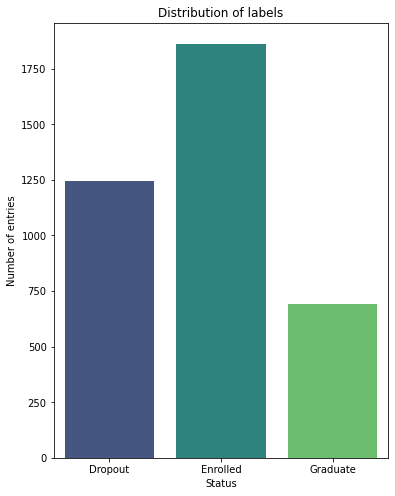

In [6]:
plt.figure(figsize=(6, 8))
sns.countplot(data=train, x = 'label', palette='viridis') # plotting the counts of each class label
plt.xticks(ticks=[0, 1, 2], labels=['Dropout', 'Enrolled', 'Graduate']) ## Labels obtained from problem statement
plt.title("Distribution of labels")
plt.xlabel("Status")
plt.ylabel("Number of entries")
plt.show()

In [7]:
dropout_rate = (train['label'] == 0).sum() / train.shape[0]
enrolled_rate = (train['label'] == 1).sum() / train.shape[0]
graduation_rate = (train['label'] == 2).sum() / train.shape[0]

In [8]:
print("Fraction of students dropped out: ", dropout_rate)
print("Fraction of students still enrolled: ", enrolled_rate)
print("Fraction of students graduated: ", graduation_rate)

Fraction of students dropped out:  0.327449947312961
Fraction of students still enrolled:  0.49077976817702845
Fraction of students graduated:  0.18177028451001054


* Dropout rate is 32.75 %. This is not a surprising number for many countries/regions.
* There is a class imbalance in the problem.

### Features and types

In [9]:
# From problem statement
feature_types = {'Binary' : ['v_1', 'v_26', 'v_11', 'v_14', 'v_30', 'v_28', 'v_9', 'v_27'],
                'Nominal' : ['v_32', 'v_4', 'v_3', 'v_20', 'v_21', 'v_18', 'v_25', 'v_12'],
                'Ordinal' : ['v_31', 'v_15', 'v_19', 'v_13', 'v_33', 'v_17', 'v_29', 'v_23', 'v_6', 'v_24', 'v_10', 'v_5', 'v_22', 'v_0'],
                'Numerical' : ['v_16', 'v_2', 'v_8', 'v_7', 'v_34', 'v_35', 'v_36', 'v_37', 'v_38', 'v_39', 'v_40']}

In [10]:
for type in feature_types.keys():
    print(type, ":", feature_types[type])
    print('count: ', len(feature_types[type]))

Binary : ['v_1', 'v_26', 'v_11', 'v_14', 'v_30', 'v_28', 'v_9', 'v_27']
count:  8
Nominal : ['v_32', 'v_4', 'v_3', 'v_20', 'v_21', 'v_18', 'v_25', 'v_12']
count:  8
Ordinal : ['v_31', 'v_15', 'v_19', 'v_13', 'v_33', 'v_17', 'v_29', 'v_23', 'v_6', 'v_24', 'v_10', 'v_5', 'v_22', 'v_0']
count:  14
Numerical : ['v_16', 'v_2', 'v_8', 'v_7', 'v_34', 'v_35', 'v_36', 'v_37', 'v_38', 'v_39', 'v_40']
count:  11


### Binary features

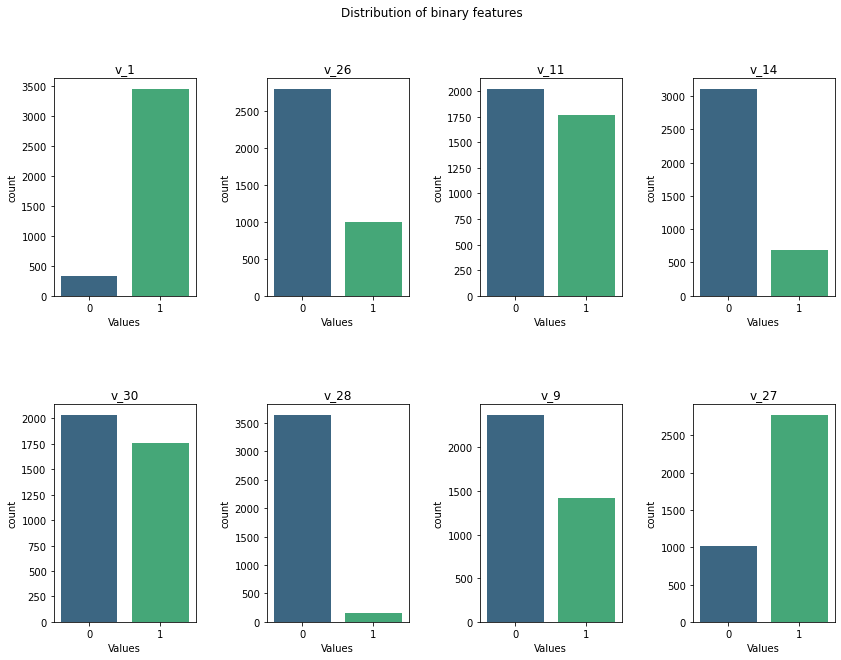

In [11]:
## Distribution of binary features 

fig = plt.figure(figsize=(14, 10))
for i, feature in enumerate(feature_types['Binary']):
    ax = plt.subplot(2, 4, i+1)
    sns.countplot(data=train, x=feature, palette='viridis',  ax=ax)
    plt.xlabel('Values')
    plt.title(feature)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle("Distribution of binary features")
plt.show()

* v_1 and v_28 have very little variability(< 10 %).

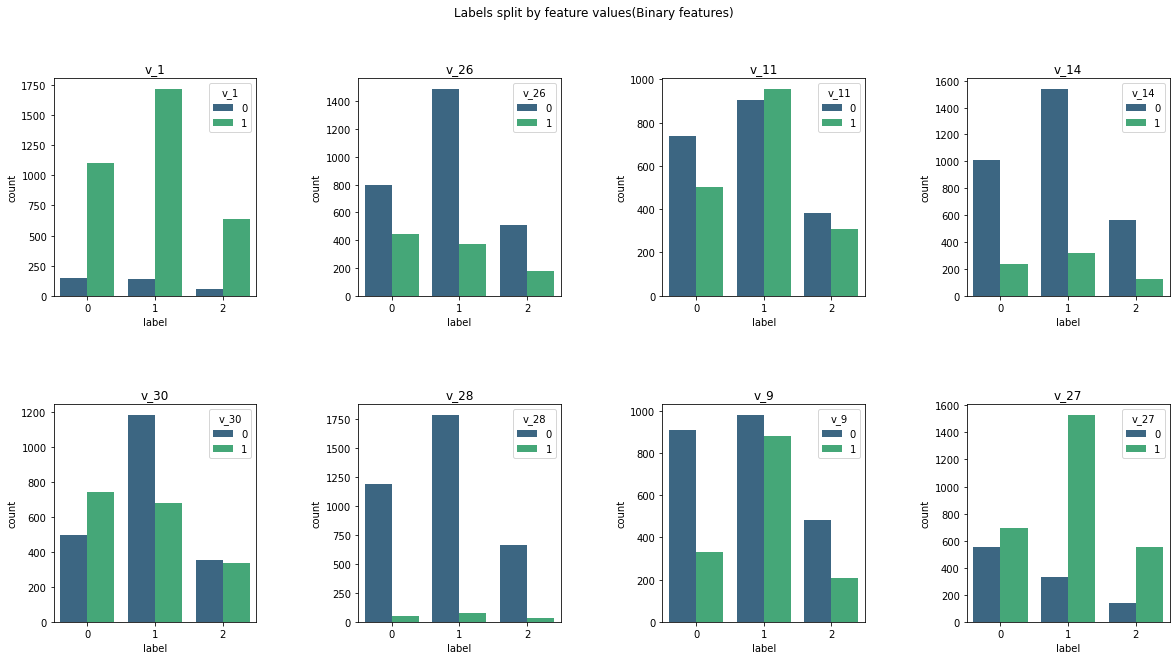

In [12]:
## Labels split by binary feature values

fig = plt.subplots(figsize=(20, 10))
for i, feature in enumerate(feature_types['Binary']):
    ax = plt.subplot(2, 4, i+1)
    sns.countplot(data=train, x = 'label', hue=feature, palette='viridis',  ax=ax)
    plt.title(feature)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle("Labels split by feature values(Binary features)")
plt.show()

### Nominal Features

In [13]:
## Cardinality of features

train[feature_types['Nominal']].nunique().sort_values()

v_21     22
v_12     37
v_25     80
v_32     84
v_18     95
v_4      98
v_20     98
v_3     124
dtype: int64

* Very high cardinality. We should be careful when doing onehot encoding

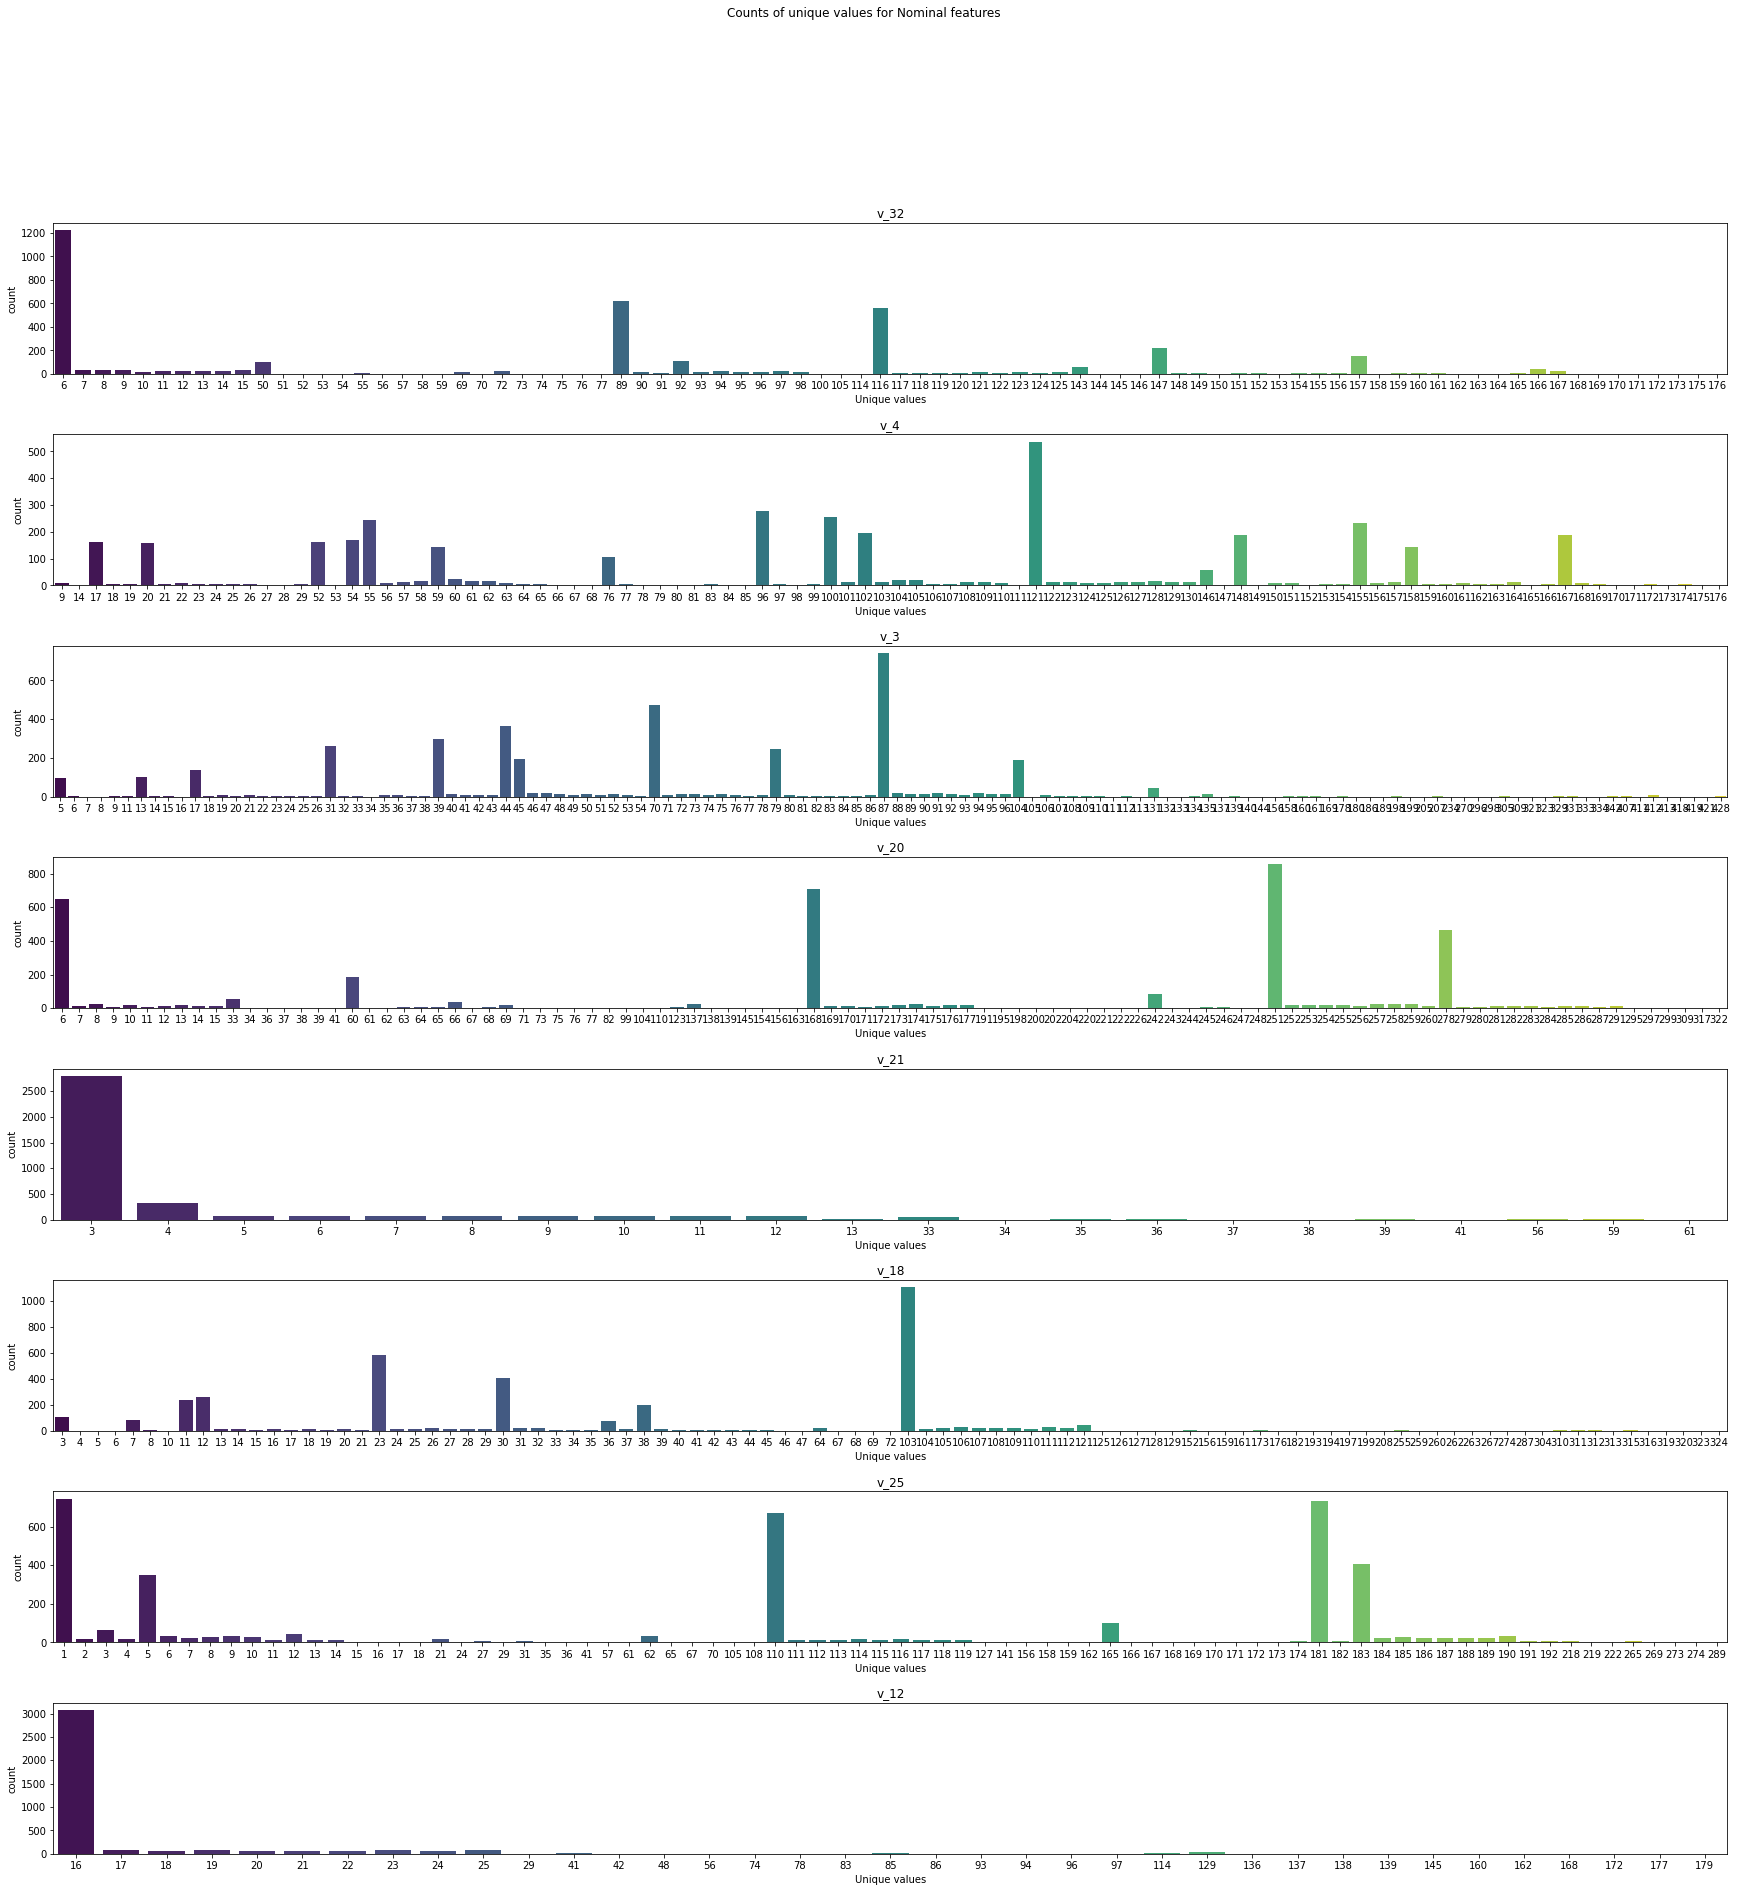

In [14]:
# Counts of unique values

fig = plt.subplots(figsize=(30, 30))
for i, feature in enumerate(feature_types['Nominal']):
    ax = plt.subplot(8, 1, i+1)
    sns.countplot(data=train, x=feature, palette='viridis', ax=ax)
    plt.xlabel('Unique values')
    plt.title(feature)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.suptitle("Counts of unique values for Nominal features")
plt.show()

* We have only a few examples for most categories in most features.
* A cutoff can be introduced to encode only those values that are adequately represented, The rest can be aggreagated to another features
* In short, cardinality may be reduced by grouping low frequency items together

### Ordinal features

In [15]:
## Cardinality

train[feature_types['Ordinal']].nunique().sort_values()

v_23    14
v_0     15
v_15    17
v_6     21
v_13    22
v_24    22
v_10    23
v_19    26
v_33    26
v_29    26
v_22    26
v_5     30
v_17    36
v_31    48
dtype: int64

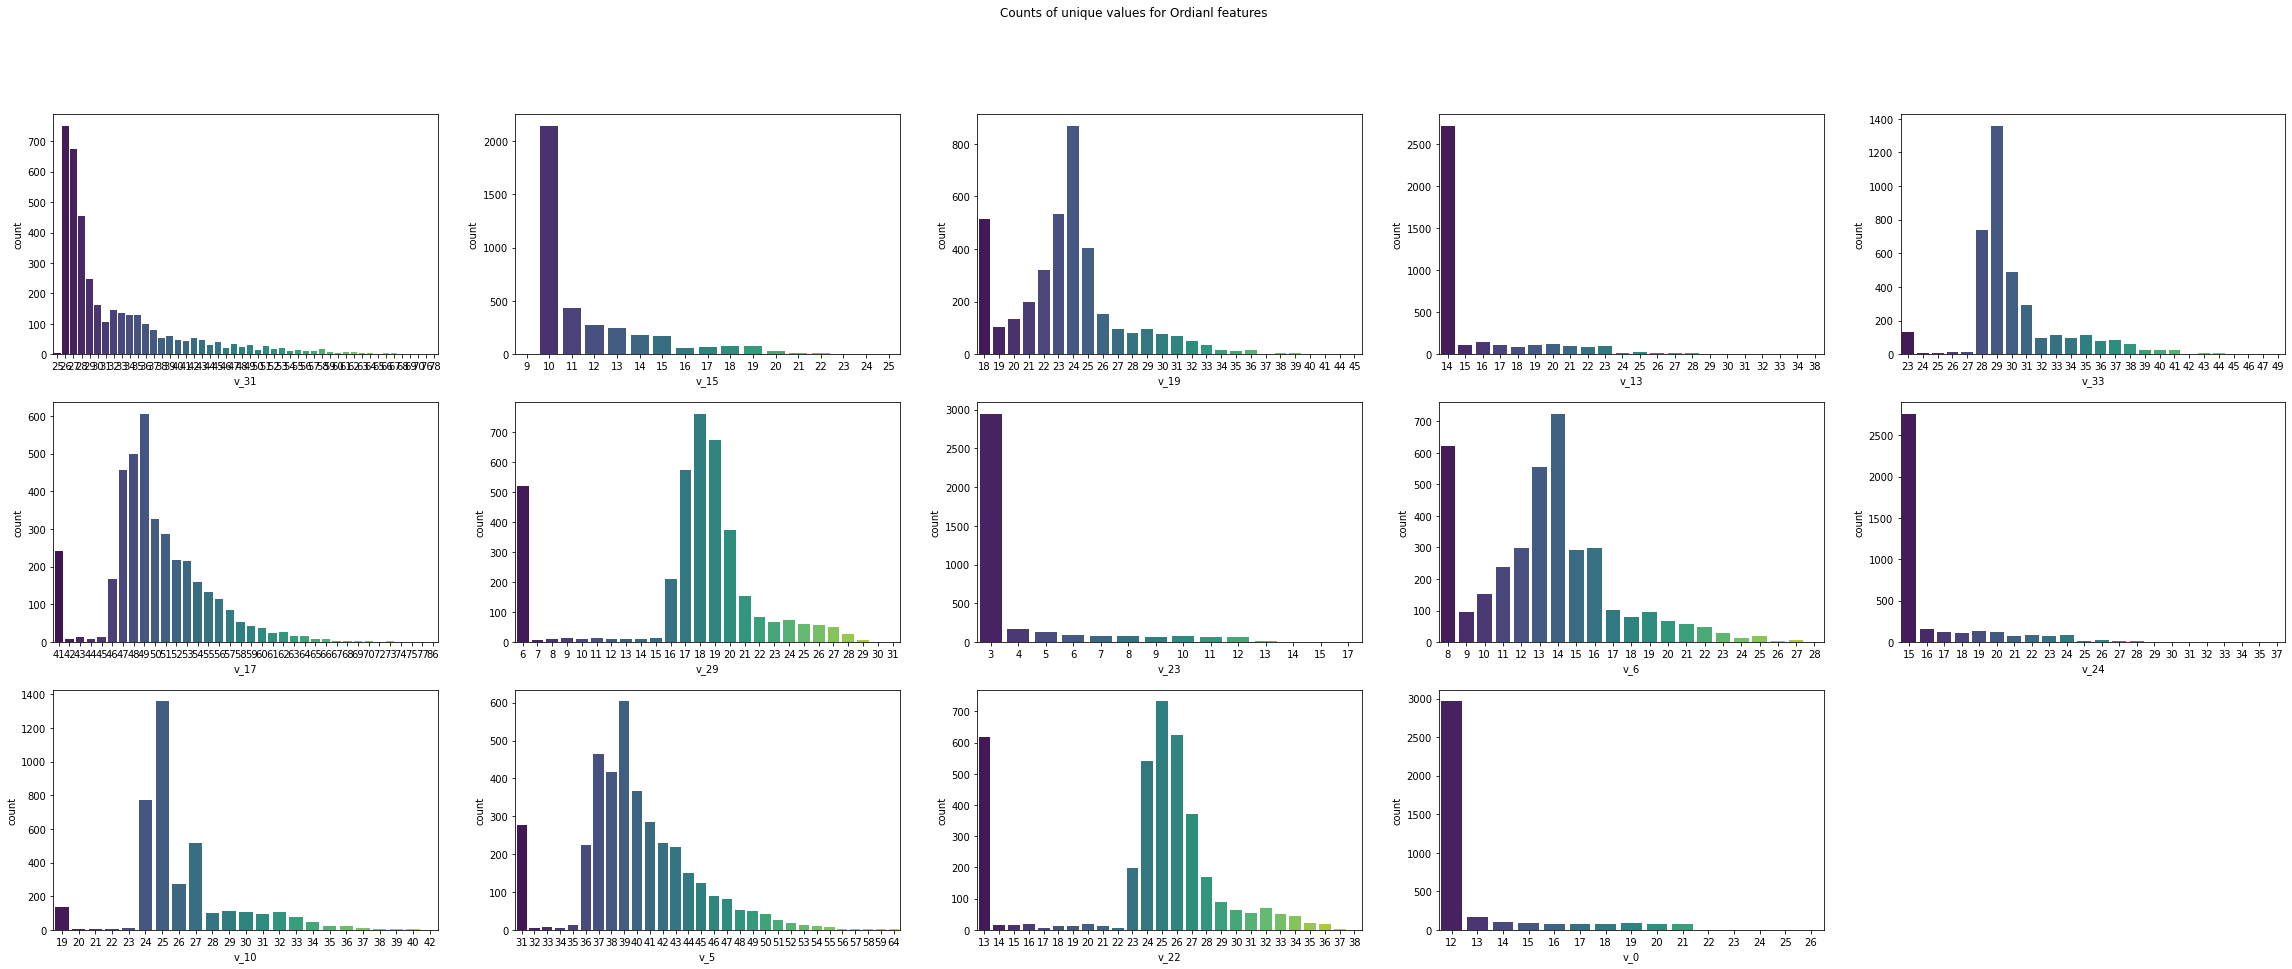

In [16]:
## Value counts

fig = plt.figure(figsize=(40, 15))
for i, feature in enumerate(feature_types['Ordinal']):
    ax = plt.subplot(3, 5, i + 1)
    sns.countplot(data=train, x=feature, palette='viridis', ax=ax)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.suptitle("Counts of unique values for Ordianl features")
plt.show()

* v_13, v_24, v_0, v_23 has very low variability.
* Looks like some aggregation might have happened on the lower end of the range in almost all features

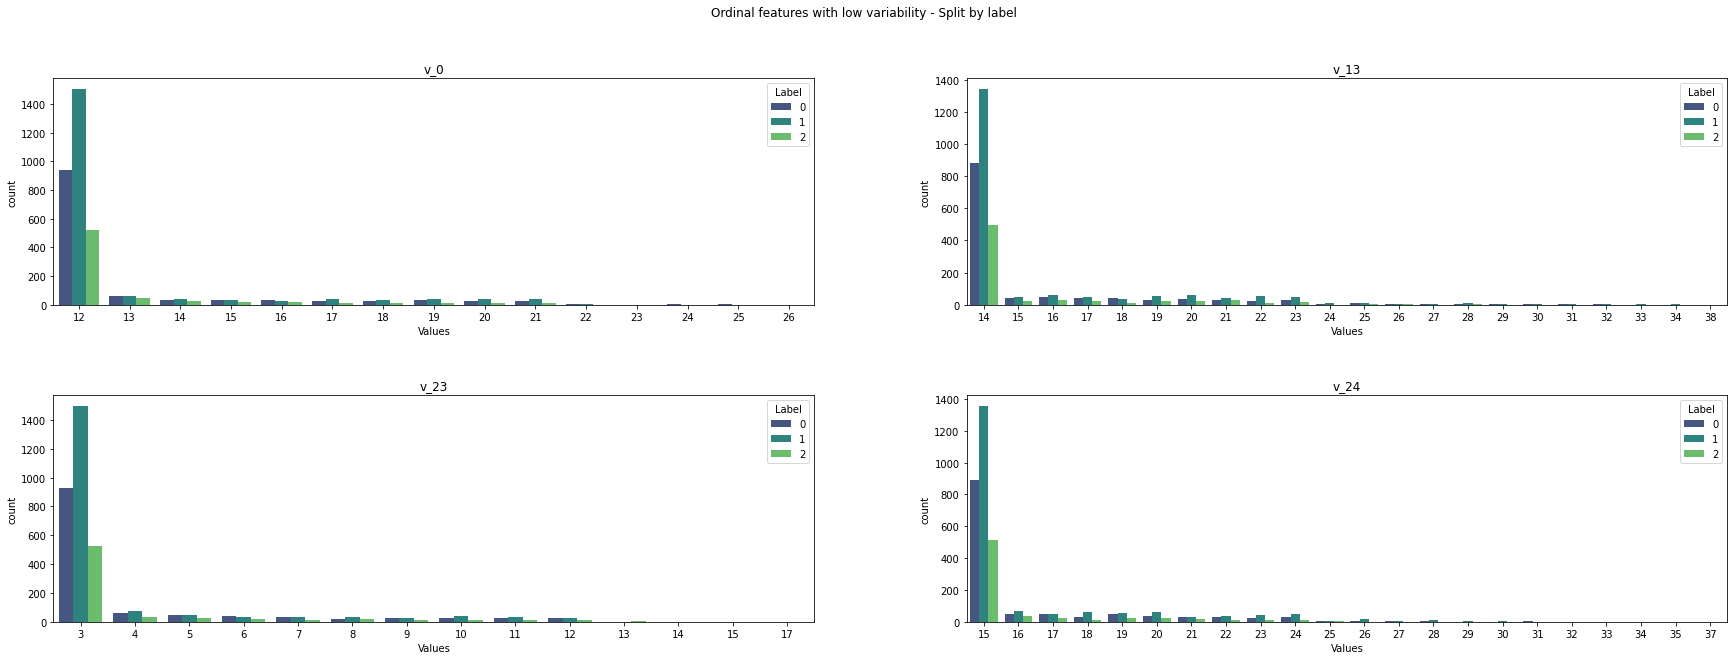

In [17]:
## A closer look at low varibility features(Split by label)

features = ['v_0','v_13', 'v_23', 'v_24']
fig = plt.figure(figsize=(30, 10))
for i, feature in enumerate(features):
    ax = plt.subplot(2, 2, i+1)
    sns.countplot(data=train, x=feature,hue='label', palette='viridis', ax=ax)
    plt.title(feature)
    plt.xlabel('Values')
    plt.legend(title='Label',loc=1)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.suptitle("Ordinal features with low variability - Split by label")
plt.show()

### Numerical features

In [18]:
train[feature_types['Numerical']].describe().T

count       mean        std   min    25%    50%    75%     max
v_16  3796.0   0.835901   3.109413 -4.06  -1.70   0.79   2.02   12.51
v_2   3796.0   2.041333   2.516779 -0.80   0.50   1.40   2.80   12.70
v_8   3796.0   3.436249   4.577644  1.00   1.00   1.00   3.00   25.00
v_7   3796.0  12.394810   3.414303  7.60   9.40  12.40  14.90   25.20
v_34  3796.0   5.341149   3.507388  0.00   3.00   5.00   8.00   18.00
v_35  3796.0  50.674658  29.330820  0.00  25.00  50.00  76.00  107.00
v_36  3796.0  26.212065  14.929649  0.00  13.00  26.00  39.00   58.00
v_37  3796.0  20.837197  11.984063  0.00  11.00  21.00  31.00   49.00
v_38  3796.0  31.276607  17.847942  0.00  16.00  31.00  47.00   69.00
v_39  3796.0  40.210485  22.466458  0.00  21.75  41.00  59.00   87.00
v_40  3796.0   3.278978   2.618851  0.00   1.00   3.00   5.00   14.00

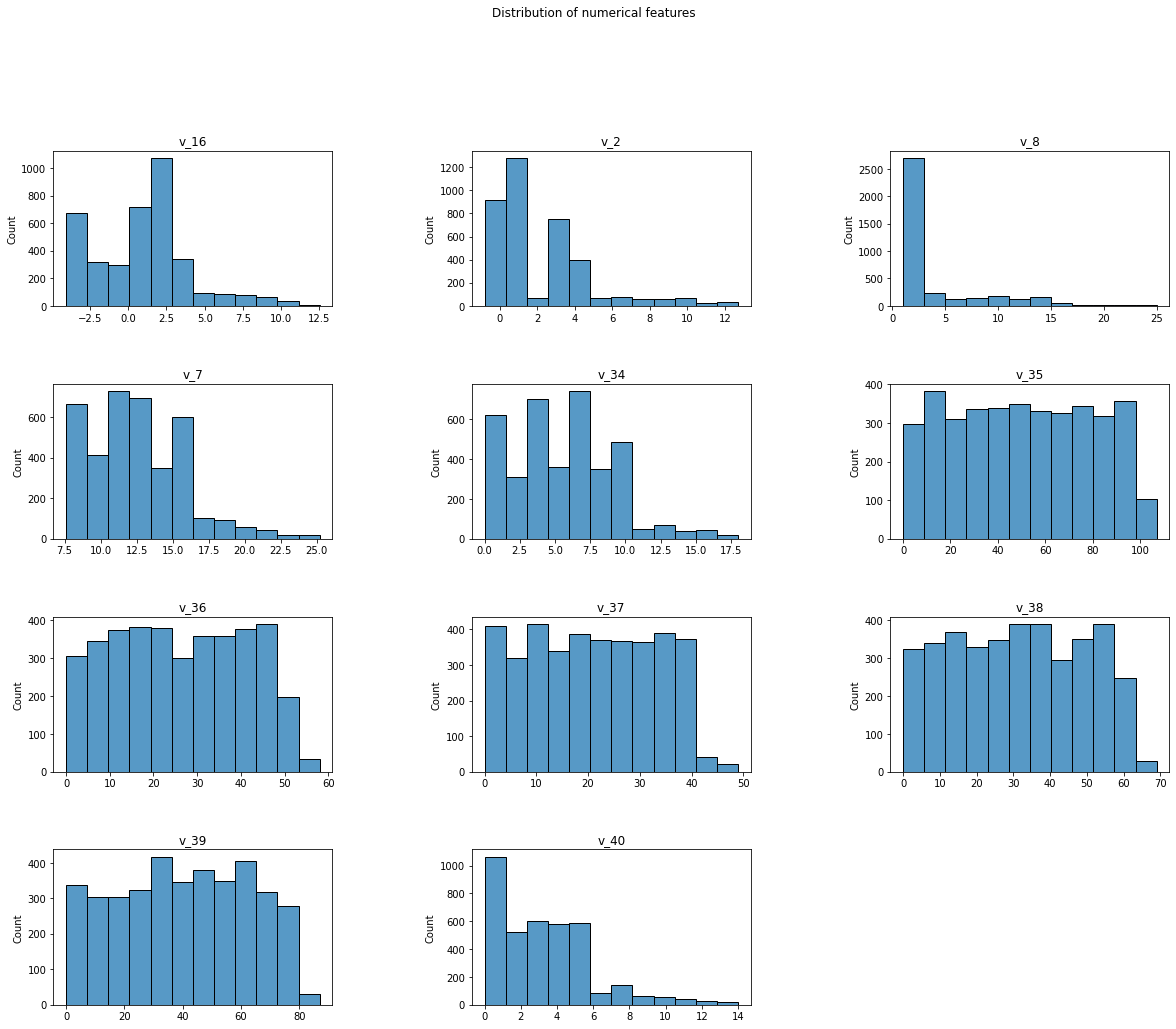

In [19]:
## Distribution - Histogram

fig = plt.figure(figsize=(20, 20))
for i, feature in enumerate(feature_types['Numerical']):
    ax = plt.subplot(5, 3, i+1)
    sns.histplot(data=train, x=feature, bins=12, palette='viridis',  ax=ax)
    plt.xlabel('')
    plt.title(feature)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle("Distribution of numerical features")
plt.show()

* v_8 has very low variability

**Visual comments on distributions**

* v_35 - v_39 looks uniformly distributed
* v_16, v_2, v_8, v_7, v_34, v_40 have long tails

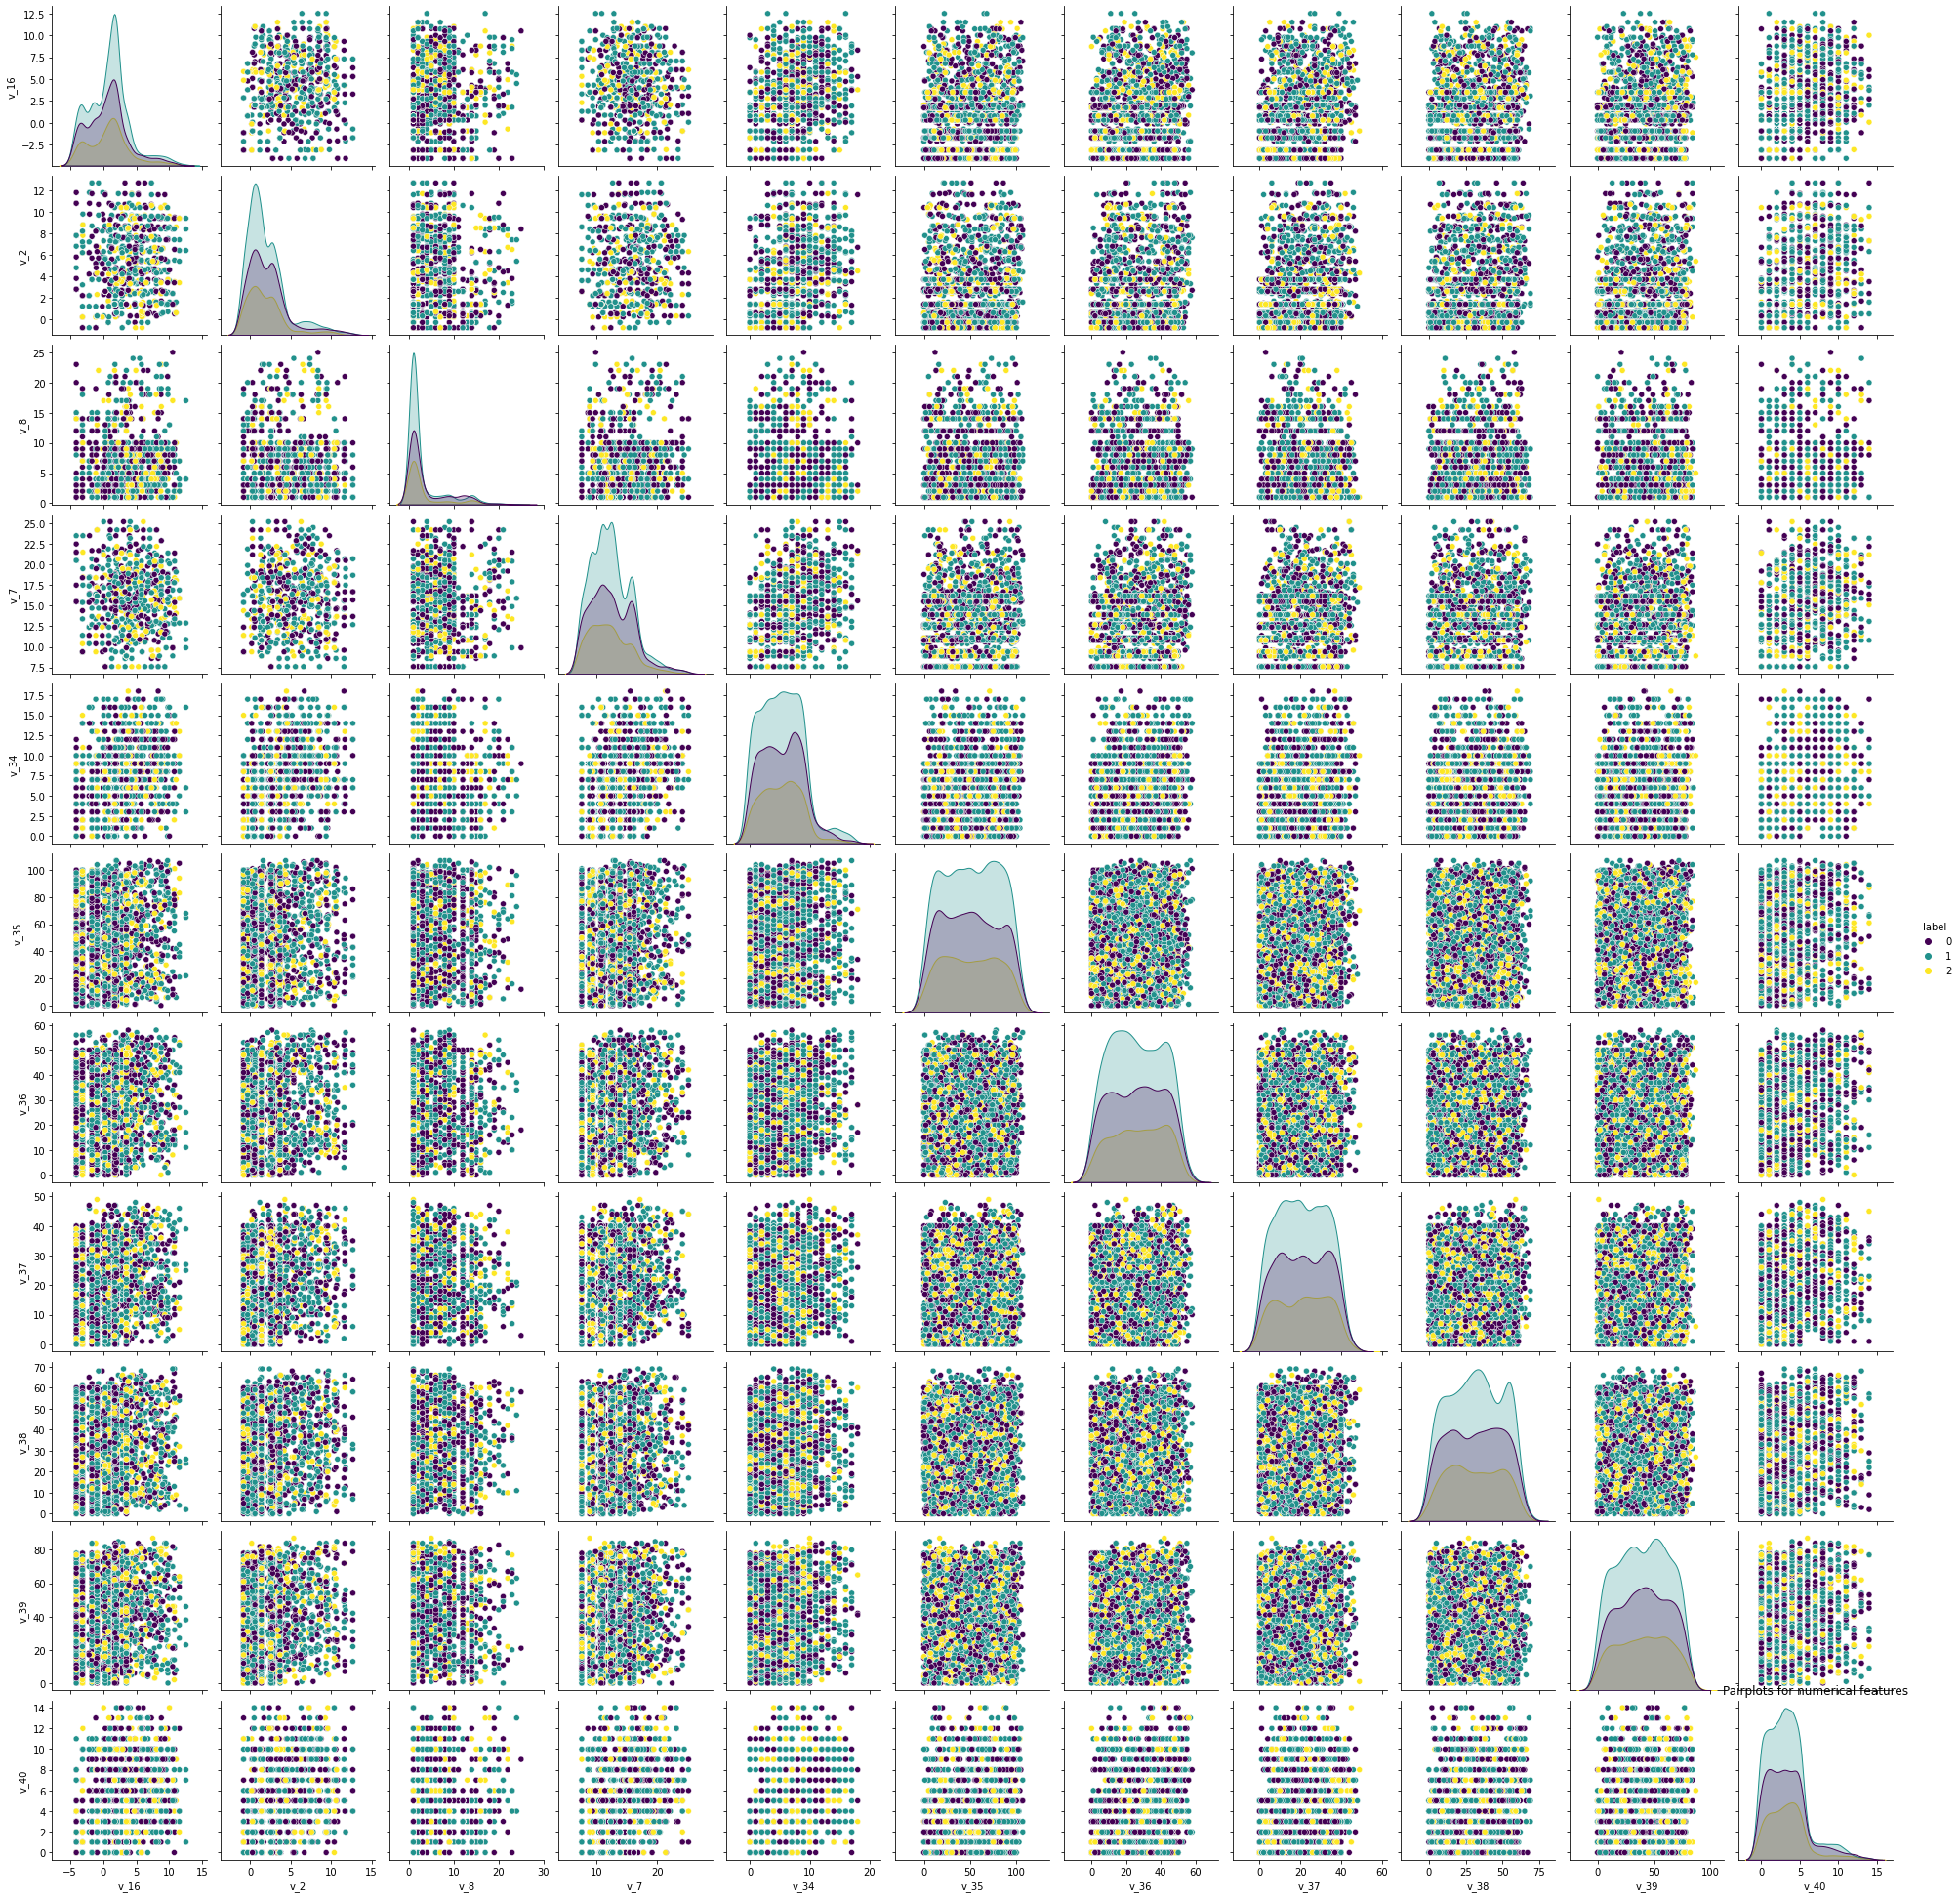

In [20]:
## Pairplots

features = feature_types['Numerical'] + ['label']
sns.pairplot(data=train[features], hue='label', palette='viridis')
plt.title("Pairplots for numerical features")
plt.show()

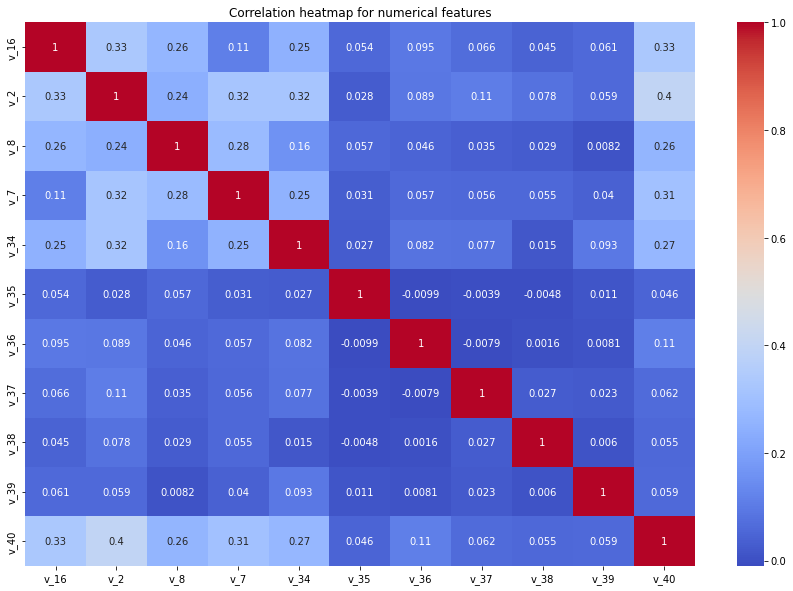

In [21]:
## Correlation

plt.figure(figsize=(15, 10))
sns.heatmap(train[feature_types['Numerical']].corr(), cmap='coolwarm', annot=True)
plt.title("Correlation heatmap for numerical features")
plt.show()

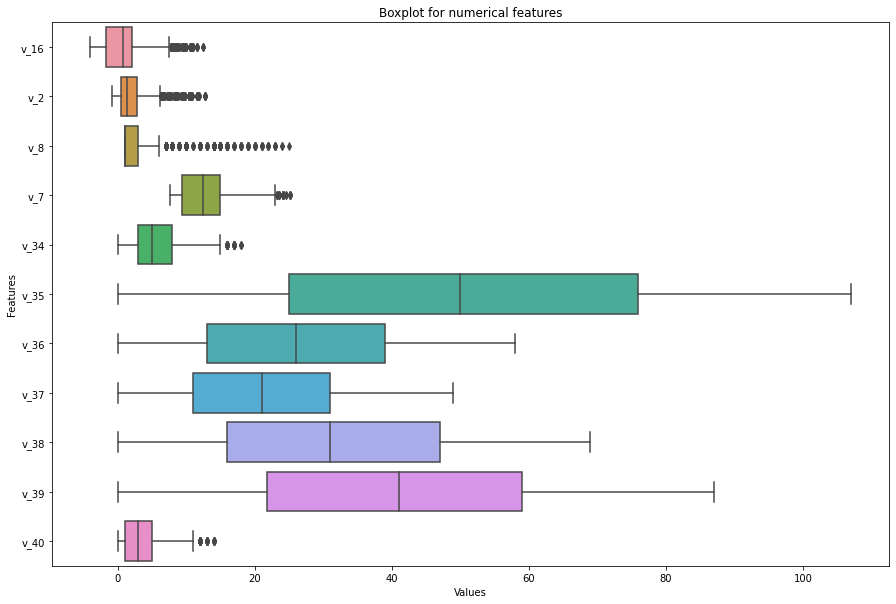

In [22]:
## Boxplots

plt.figure(figsize=(15, 10))
sns.boxplot(data=train[feature_types['Numerical']], orient='horizontal')
plt.title("Boxplot for numerical features")
plt.xlabel('Values')
plt.ylabel('Features')
plt.show()

* There are outliers in features v_2, v_7, v_8, v_16, v_40

### EDA - Summary

* Data set has 3796 entries, 43 columns including label
* No missing values
* There are 41 features, of which 30 are categorical and 11 are numerical. The categorical features can be further classified as; 8 binary features, 8 nominal features and 14 ordinal features.
* Dropout rate is 32.75 %. This is not a surprising number for many countries/regions.
* There is a class imbalance in the problem(~33% dropouts, ~49% enrolled, ~18% graduated)
* Some features show very little variability. We can consider dropping them
* Nominal features have very high cardinality. Most categories in all these features are poorly represented
* There are no significant correlations between numerical features. 
* Some numerical features have outliers


## Preprocessing

In [23]:
# Binary features don't need any encoding
binary_transformers = ColumnTransformer([('select', 'passthrough', feature_types['Binary'])])

# Nominal encoding
nominal_transformers = Pipeline([('selector', ColumnTransformer([('select', 'passthrough', feature_types['Nominal'])])),
                                ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
# Ordinal encoding
ordinal_transformers = Pipeline([('selector', ColumnTransformer([('select', 'passthrough', feature_types['Ordinal'])])),
                                ('ordinal-enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)),
                                ('scaler', MinMaxScaler())])

#Ratio transformers - Scaling for numerical features
ratio_transformers = Pipeline([('selector', ColumnTransformer([('select', 'passthrough', feature_types['Numerical'])])),
                               ('scaler', MinMaxScaler())])

#Preprocess pipeline
preprocess_pipe = FeatureUnion(transformer_list=[('binary', binary_transformers),
                                                ('ordinal', ordinal_transformers),
                                                ('nominal', nominal_transformers),
                                                ('numerical', ratio_transformers)])

## Some helper functions

We are planning to apply different models on the data. Since fitting and tuning models are a repetitive task, let's write some helper functions to make our lives easier

In [24]:
def construct_pipeline(classifier, preprocessor):
    '''constructs pipeline object by combining a preprocessing stage and an estimator
    Args:
        classifier: Estimator object
        preprocessor: Preprocessing transformer object
        
    Returns:
        pipeline object
    '''
    full_pipe = Pipeline([('preprocess', preprocessor),
                        ('clf', classifier )])
    return full_pipe
    
def train_model(classifier, preprocessor, X_train, y_train):
    '''Trains a model with on given preprocssing and classification stages
    Args:
        classifier: Estimator object
        preprocessor: Preprocessing transformer object
        X_train: Training data feature matrix
        y_train: Training data label vector
        
    Returns:
        trained model
    '''
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=10)
    
    full_pipe = construct_pipeline(classifier, preprocessor)
    full_pipe.fit(X_train, y_train)
    
    print("-------------------Metrics on training set --------------------------")
    y_train_pred = full_pipe.predict(X_train)
    print("F1 score on training set: ", f1_score(y_train, y_train_pred, average='micro'))
    print()
    print(classification_report(y_train, y_train_pred))

    
    print("-------------------Metrics on test set --------------------------")
    y_test_pred = full_pipe.predict(X_test)
    print("F1 score on test set: " ,f1_score(y_test, y_test_pred, average='micro'))
    print()
    print(classification_report(y_test, y_test_pred))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    
    return full_pipe

    
def tune_model(model, param_grid, X_train, y_train, cv = 5):
    '''Do hyper parameter tuning using GridSearch strategy
    
    Args:
        model: Model to be tuned
        param_grid: dict of parameters
        X_train: Feature matrix
        y_train: Label matrix
        
    Returns: 
        best parameters
        best estimator
    '''
    search = GridSearchCV(model, param_grid = param_grid,
                          cv = cv,
                          scoring='f1_micro',
                          return_train_score=True)
    search.fit(X_train, y_train)
    
    print("Best parameters: ", search.best_params_)
    print("-------------------Best model performance --------------------------")
    
    mean_train_score = search.cv_results_['mean_train_score'][search.best_index_]
    mean_test_score = search.cv_results_['mean_test_score'][search.best_index_]
    std_train_score = search.cv_results_['std_train_score'][search.best_index_]
    std_test_score = search.cv_results_['std_test_score'][search.best_index_]

    print(f"Score of the model on the train set:\n"
        f"{mean_train_score:.3f} +/- {std_train_score:.6f}")

    print(f"Score of the model on the test set:\n"
        f"{mean_test_score:.3f} +/- {std_test_score:.6f}")
    
    y_pred = search.best_estimator_.predict(X_train)
    print(classification_report(y_train, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
    
    print("------------------------------------------------------------------")
    
    return search.best_estimator_

Let's seperate features and labels

In [25]:
y_train = train['label']
X_train = train.drop(columns=['id', 'label'])

## Baseline models
Baseline models are necessary to access and compare performance of various models. We consider two approaches to construct a baseline.
1. A naive baseline with ~DummyClassifier~ which predicts majority class for all data
2. K Nearest Neighbour model - This model directly estimates $(y | x)$ based on the neighbourhood in feature space. 

### Naive baseline

Training a dummy classifier

-------------------Metrics on training set --------------------------
F1 score on training set:  0.49110671936758893

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       991
           1       0.49      1.00      0.66      1491
           2       0.00      0.00      0.00       554

    accuracy                           0.49      3036
   macro avg       0.16      0.33      0.22      3036
weighted avg       0.24      0.49      0.32      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.48947368421052634

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       252
           1       0.49      1.00      0.66       372
           2       0.00      0.00      0.00       136

    accuracy                           0.49       760
   macro avg       0.16      0.33      0.22       760
weighted avg       0.24      0.49      0.32       760



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

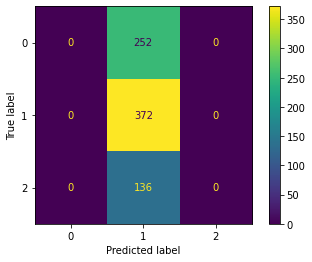

In [26]:
dummy_clf = DummyClassifier()
baseline_model_dummy = train_model(dummy_clf, preprocess_pipe, X_train, y_train)

### K Nearest Neighbours

Training K Nearest Neighbour model

-------------------Metrics on training set --------------------------
F1 score on training set:  0.7035573122529645

              precision    recall  f1-score   support

           0       0.72      0.69      0.70       991
           1       0.70      0.89      0.78      1491
           2       0.66      0.23      0.34       554

    accuracy                           0.70      3036
   macro avg       0.69      0.60      0.61      3036
weighted avg       0.70      0.70      0.68      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.5618421052631579

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       252
           1       0.60      0.77      0.67       372
           2       0.29      0.08      0.13       136

    accuracy                           0.56       760
   macro avg       0.47      0.45      0.44       760
weighted avg       0.52      0.56      0.53       760



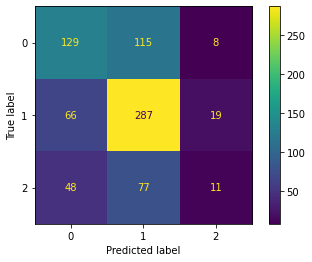

In [27]:
knn = KNeighborsClassifier()
baseline_model_knn = train_model(knn, preprocess_pipe, X_train, y_train)

Tuning parameters,

Best parameters:  {'clf__n_neighbors': 27}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.623 +/- 0.005562
Score of the model on the test set:
0.604 +/- 0.004990
              precision    recall  f1-score   support

           0       0.75      0.47      0.58      1243
           1       0.60      0.94      0.73      1863
           2       0.49      0.06      0.10       690

    accuracy                           0.63      3796
   macro avg       0.61      0.49      0.47      3796
weighted avg       0.63      0.63      0.57      3796

------------------------------------------------------------------


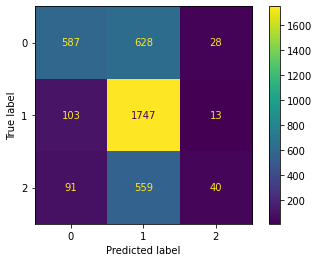

In [28]:
param_grid = {'clf__n_neighbors': range(1, 30, 2)}
tuned_knn_model = tune_model(baseline_model_knn, param_grid, X_train, y_train)

## Linear Models

Let's try the simplest models with linear decision boundaries.

### Ridge Classifier

-------------------Metrics on training set --------------------------
F1 score on training set:  0.8138998682476943

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       991
           1       0.79      0.97      0.87      1491
           2       0.78      0.40      0.53       554

    accuracy                           0.81      3036
   macro avg       0.81      0.73      0.75      3036
weighted avg       0.81      0.81      0.80      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7223684210526314

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       252
           1       0.73      0.88      0.80       372
           2       0.44      0.22      0.29       136

    accuracy                           0.72       760
   macro avg       0.65      0.62      0.62       760
weighted avg       0.70      0.72      0.70       760



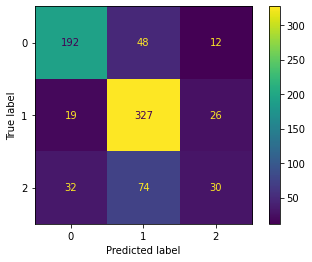

In [29]:
ridge_clf = train_model(RidgeClassifier(), preprocess_pipe, X_train, y_train)

Tuning with regularisation, alpha

Best parameters:  {'clf__alpha': 10}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.782 +/- 0.001583
Score of the model on the test set:
0.720 +/- 0.008052
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1243
           1       0.75      0.96      0.84      1863
           2       0.75      0.27      0.40       690

    accuracy                           0.78      3796
   macro avg       0.78      0.67      0.68      3796
weighted avg       0.78      0.78      0.75      3796

------------------------------------------------------------------


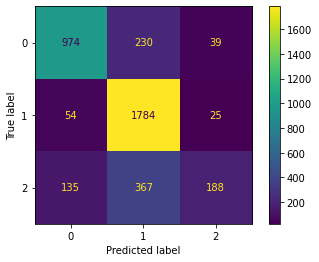

In [30]:
ridge_clf = construct_pipeline(RidgeClassifier(alpha=10), preprocess_pipe)
param_grid = {'clf__alpha': (0.001, 0.01, 0.1, 1, 10, 100)}
tuned_ridge = tune_model(ridge_clf, param_grid, X_train, y_train)

### Logistic Regression

-------------------Metrics on training set --------------------------
F1 score on training set:  0.8204874835309618

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       991
           1       0.82      0.95      0.88      1491
           2       0.73      0.49      0.58       554

    accuracy                           0.82      3036
   macro avg       0.80      0.75      0.77      3036
weighted avg       0.82      0.82      0.81      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7263157894736842

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       252
           1       0.76      0.85      0.80       372
           2       0.51      0.33      0.40       136

    accuracy                           0.73       760
   macro avg       0.67      0.65      0.65       760
weighted avg       0.71      0.73      0.71       760



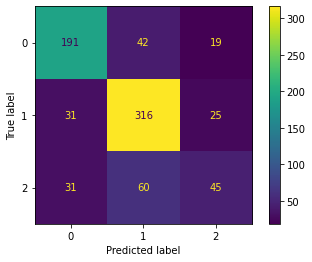

In [31]:
log_reg = train_model(LogisticRegression(max_iter=2000), preprocess_pipe, X_train, y_train)

c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters:  {'clf__C': 1, 'clf__l1_ratio': 0.5}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.806 +/- 0.004215
Score of the model on the test set:
0.736 +/- 0.013627
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1243
           1       0.80      0.94      0.86      1863
           2       0.68      0.43      0.53       690

    accuracy                           0.80      3796
   macro avg       0.77      0.72      0.74      3796
weighted avg       0.79      0.80      0.79      3796

------------------------------------------------------------------


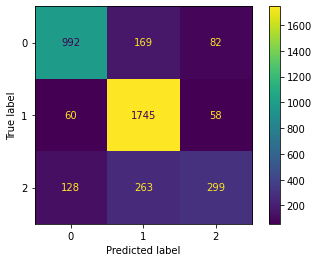

In [32]:
log_reg = construct_pipeline(LogisticRegression(penalty= 'elasticnet',solver='saga', max_iter=2000), preprocess_pipe)
param_grid = {'clf__C': ( 0.001, 0.01, 0.1, 1, 10),
             'clf__l1_ratio': (0, 0.1, 0.3, 0.5, 0.7, 0.9, 1)}
tuned_log_reg = tune_model(log_reg, param_grid, X_train, y_train)

### Softmax Regression

-------------------Metrics on training set --------------------------
F1 score on training set:  0.8204874835309618

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       991
           1       0.82      0.95      0.88      1491
           2       0.73      0.49      0.58       554

    accuracy                           0.82      3036
   macro avg       0.80      0.75      0.77      3036
weighted avg       0.82      0.82      0.81      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7263157894736842

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       252
           1       0.76      0.85      0.80       372
           2       0.51      0.33      0.40       136

    accuracy                           0.73       760
   macro avg       0.67      0.65      0.65       760
weighted avg       0.71      0.73      0.71       760



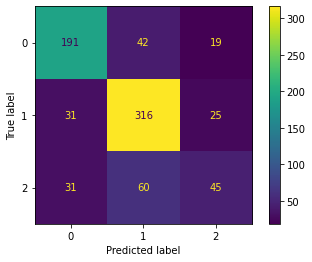

In [33]:
softmax_reg = train_model(LogisticRegression(multi_class='multinomial', max_iter=2000), preprocess_pipe, X_train, y_train)

Best parameters:  {'clf__C': 1, 'clf__l1_ratio': 0.5}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.806 +/- 0.004040
Score of the model on the test set:
0.737 +/- 0.013488
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1243
           1       0.80      0.94      0.86      1863
           2       0.68      0.43      0.53       690

    accuracy                           0.80      3796
   macro avg       0.77      0.72      0.74      3796
weighted avg       0.79      0.80      0.79      3796

------------------------------------------------------------------


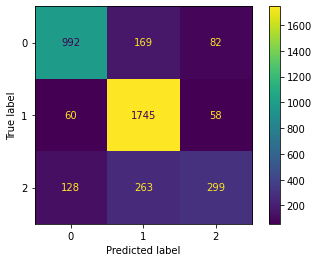

In [34]:
softmax_reg = construct_pipeline(LogisticRegression(multi_class = 'multinomial', penalty= 'elasticnet',solver='saga', max_iter=2000), preprocess_pipe)
param_grid = {'clf__C': ( 0.1, 1, 10),
             'clf__l1_ratio': (0.3, 0.5, 0.7)}
tuned_softmax = tune_model(softmax_reg, param_grid, X_train, y_train)

### Support Vector Machines - Linear kernel

-------------------Metrics on training set --------------------------
F1 score on training set:  0.8392621870882742

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       991
           1       0.83      0.96      0.89      1491
           2       0.78      0.51      0.61       554

    accuracy                           0.84      3036
   macro avg       0.83      0.77      0.79      3036
weighted avg       0.84      0.84      0.83      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7236842105263158

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       252
           1       0.76      0.84      0.80       372
           2       0.48      0.32      0.39       136

    accuracy                           0.72       760
   macro avg       0.66      0.64      0.65       760
weighted avg       0.71      0.72      0.71       760



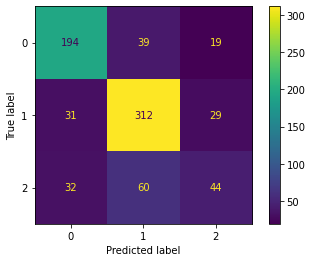

In [35]:
lin_svm = train_model(LinearSVC(), preprocess_pipe, X_train, y_train)

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be

Best parameters:  {'clf__C': 0.1, 'clf__penalty': 'l2'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.804 +/- 0.002342
Score of the model on the test set:
0.726 +/- 0.008941
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1243
           1       0.79      0.95      0.86      1863
           2       0.73      0.37      0.49       690

    accuracy                           0.80      3796
   macro avg       0.79      0.71      0.73      3796
weighted avg       0.79      0.80      0.78      3796

------------------------------------------------------------------


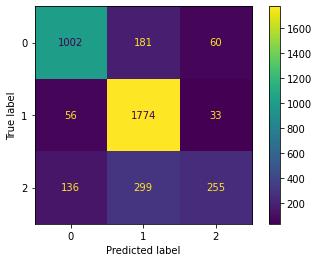

In [36]:
lin_svm = construct_pipeline(LinearSVC(max_iter=10000), preprocess_pipe)
param_grid = {'clf__penalty': ('l1', 'l2'),
              'clf__C': (0.001, 0.01, 0.1, 1, 10, 100)}
tuned_lin_svm = tune_model(lin_svm, param_grid, X_train, y_train)

## Decision Tree

-------------------Metrics on training set --------------------------
F1 score on training set:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       1.00      1.00      1.00      1491
           2       1.00      1.00      1.00       554

    accuracy                           1.00      3036
   macro avg       1.00      1.00      1.00      3036
weighted avg       1.00      1.00      1.00      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.6526315789473685

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       252
           1       0.78      0.72      0.75       372
           2       0.34      0.38      0.36       136

    accuracy                           0.65       760
   macro avg       0.60      0.60      0.60       760
weighted avg       0.66      0.65      0.66       760



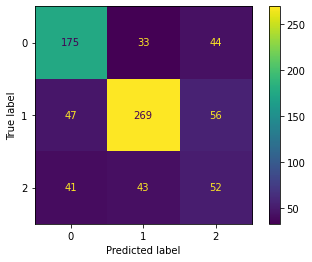

In [37]:
dtree = train_model(DecisionTreeClassifier(), preprocess_pipe, X_train, y_train)

Best parameters:  {'clf__ccp_alpha': 0.001, 'clf__max_depth': 5}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.744 +/- 0.006885
Score of the model on the test set:
0.718 +/- 0.009256
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1243
           1       0.73      0.95      0.83      1863
           2       0.58      0.31      0.40       690

    accuracy                           0.75      3796
   macro avg       0.72      0.65      0.66      3796
weighted avg       0.74      0.75      0.73      3796

------------------------------------------------------------------


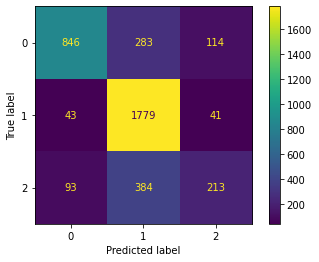

In [38]:
dtree_pipe = construct_pipeline(DecisionTreeClassifier(), preprocess_pipe)
param_grid = {'clf__max_depth': (2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 35, 30, 35, 40),
              'clf__ccp_alpha': (1e-4, 0.0005,1e-3, 1e-2, 0.025, 0.005, 0.075, 1e-1)}
tuned_dtree = tune_model(dtree_pipe, param_grid, X_train, y_train)

### Decision tree without any preprocessing

-------------------Metrics on training set --------------------------
F1 score on training set:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       1.00      1.00      1.00      1491
           2       1.00      1.00      1.00       554

    accuracy                           1.00      3036
   macro avg       1.00      1.00      1.00      3036
weighted avg       1.00      1.00      1.00      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.6355263157894737

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       252
           1       0.79      0.70      0.74       372
           2       0.34      0.45      0.39       136

    accuracy                           0.64       760
   macro avg       0.59      0.60      0.59       760
weighted avg       0.66      0.64      0.65       760



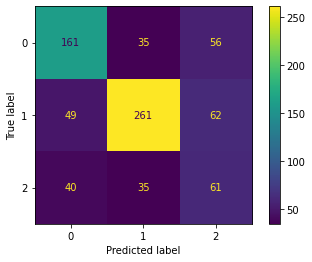

In [39]:
dtree = train_model(DecisionTreeClassifier(), None, X_train, y_train)

Best parameters:  {'clf__ccp_alpha': 0.0005, 'clf__max_depth': 5}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.744 +/- 0.005115
Score of the model on the test set:
0.715 +/- 0.007103
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      1243
           1       0.72      0.96      0.82      1863
           2       0.58      0.28      0.38       690

    accuracy                           0.75      3796
   macro avg       0.72      0.64      0.65      3796
weighted avg       0.74      0.75      0.72      3796

------------------------------------------------------------------


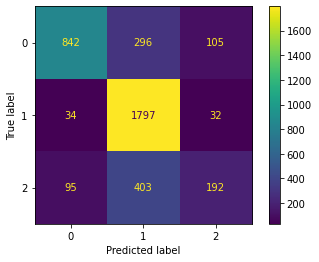

In [40]:

dtree_pipe = construct_pipeline(DecisionTreeClassifier(), None)
param_grid = {'clf__max_depth': (2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 35, 30, 35, 40),
              'clf__ccp_alpha': (1e-4, 0.0005,1e-3, 1e-2, 0.025, 0.005, 0.075, 1e-1)}
tuned_dtree = tune_model(dtree_pipe, param_grid, X_train, y_train)

## Ensemble methods

### Random Forest

-------------------Metrics on training set --------------------------
F1 score on training set:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       1.00      1.00      1.00      1491
           2       1.00      1.00      1.00       554

    accuracy                           1.00      3036
   macro avg       1.00      1.00      1.00      3036
weighted avg       1.00      1.00      1.00      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7328947368421054

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       252
           1       0.73      0.92      0.81       372
           2       0.68      0.20      0.31       136

    accuracy                           0.73       760
   macro avg       0.72      0.62      0.62       760
weighted avg       0.73      0.73      0.70       760



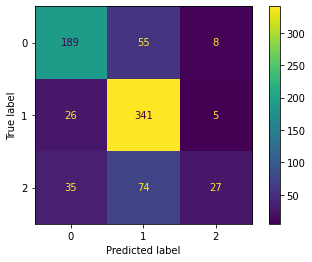

In [42]:
rf = train_model(RandomForestClassifier(), preprocess_pipe, X_train, y_train)

Best parameters:  {'clf__min_samples_split': 6, 'clf__n_estimators': 150}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.973 +/- 0.000998
Score of the model on the test set:
0.741 +/- 0.008973
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1243
           1       0.96      1.00      0.98      1863
           2       1.00      0.93      0.97       690

    accuracy                           0.98      3796
   macro avg       0.98      0.97      0.97      3796
weighted avg       0.98      0.98      0.98      3796

------------------------------------------------------------------


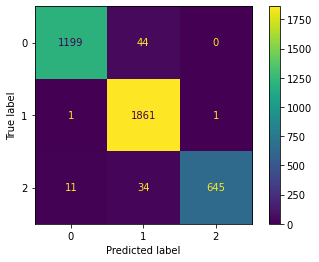

In [45]:
rf_pipe = construct_pipeline(RandomForestClassifier(), preprocess_pipe)
param_grid = {'clf__n_estimators': (100, 150, 200, 250, 300, 350),
             'clf__min_samples_split':range(2, 10)}
tuned_rf = tune_model(rf_pipe, param_grid, X_train, y_train)

### Random Forest - Without preprocessing

-------------------Metrics on training set --------------------------
F1 score on training set:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       1.00      1.00      1.00      1491
           2       1.00      1.00      1.00       554

    accuracy                           1.00      3036
   macro avg       1.00      1.00      1.00      3036
weighted avg       1.00      1.00      1.00      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7434210526315789

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       252
           1       0.76      0.91      0.83       372
           2       0.55      0.26      0.36       136

    accuracy                           0.74       760
   macro avg       0.69      0.64      0.65       760
weighted avg       0.72      0.74      0.72       760



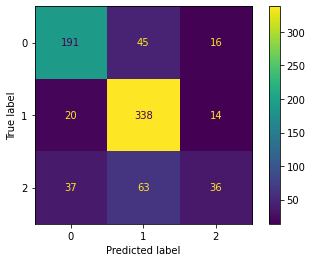

In [46]:
rf = train_model(RandomForestClassifier(n_estimators=300), None, X_train, y_train)

Best parameters:  {'clf__min_samples_split': 2, 'clf__n_estimators': 100}
-------------------Best model performance --------------------------
Score of the model on the train set:
1.000 +/- 0.000000
Score of the model on the test set:
0.743 +/- 0.009907
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1243
           1       1.00      1.00      1.00      1863
           2       1.00      1.00      1.00       690

    accuracy                           1.00      3796
   macro avg       1.00      1.00      1.00      3796
weighted avg       1.00      1.00      1.00      3796

------------------------------------------------------------------


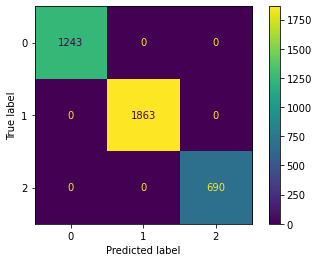

In [47]:
rf_pipe = construct_pipeline(RandomForestClassifier(), None)
param_grid = {'clf__n_estimators': range(100, 120, 5),
             'clf__min_samples_split':range(2, 10)}
tuned_rf = tune_model(rf_pipe, param_grid, X_train, y_train)

# Adaboost

-------------------Metrics on training set --------------------------
F1 score on training set:  0.7470355731225296

              precision    recall  f1-score   support

           0       0.78      0.73      0.76       991
           1       0.77      0.90      0.83      1491
           2       0.53      0.36      0.43       554

    accuracy                           0.75      3036
   macro avg       0.70      0.66      0.67      3036
weighted avg       0.73      0.75      0.73      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7171052631578947

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       252
           1       0.76      0.85      0.80       372
           2       0.49      0.33      0.39       136

    accuracy                           0.72       760
   macro avg       0.66      0.64      0.64       760
weighted avg       0.70      0.72      0.71       760



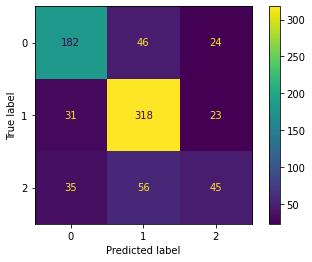

In [48]:
ada = train_model(AdaBoostClassifier(), preprocess_pipe, X_train, y_train)

Best parameters:  {'clf__learning_rate': 1, 'clf__n_estimators': 50}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.742 +/- 0.004475
Score of the model on the test set:
0.720 +/- 0.011958
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1243
           1       0.77      0.89      0.83      1863
           2       0.50      0.36      0.42       690

    accuracy                           0.74      3796
   macro avg       0.68      0.65      0.66      3796
weighted avg       0.72      0.74      0.73      3796

------------------------------------------------------------------


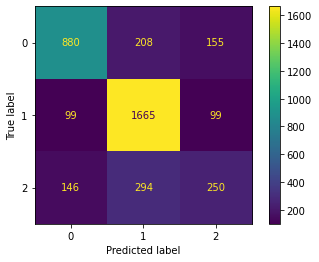

In [49]:
ada_pipe = construct_pipeline(AdaBoostClassifier(), preprocess_pipe)
param_grid = {'clf__n_estimators': (50, 75, 100, 125, 150),
             'clf__learning_rate': (1e-3, 1e-2, 1e-1, 1)}
tuned_ada = tune_model(ada_pipe, param_grid, X_train, y_train)

Let's try using another base estimator

-------------------Metrics on training set --------------------------
F1 score on training set:  0.7648221343873517

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       991
           1       0.81      0.89      0.84      1491
           2       0.56      0.45      0.50       554

    accuracy                           0.76      3036
   macro avg       0.72      0.70      0.71      3036
weighted avg       0.76      0.76      0.76      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.6921052631578948

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       252
           1       0.76      0.78      0.77       372
           2       0.45      0.38      0.41       136

    accuracy                           0.69       760
   macro avg       0.64      0.63      0.63       760
weighted avg       0.68      0.69      0.69       760



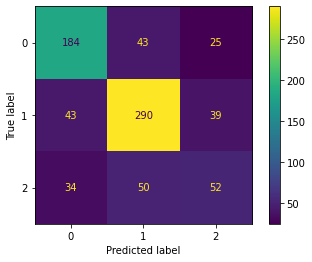

In [50]:
svm = LinearSVC()
ada = train_model(AdaBoostClassifier(base_estimator=svm, algorithm='SAMME'), preprocess_pipe, X_train, y_train)

Best parameters:  {'clf__learning_rate': 0.1, 'clf__n_estimators': 150}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.770 +/- 0.003253
Score of the model on the test set:
0.712 +/- 0.014889
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1243
           1       0.83      0.84      0.84      1863
           2       0.53      0.52      0.52       690

    accuracy                           0.76      3796
   macro avg       0.71      0.71      0.71      3796
weighted avg       0.76      0.76      0.76      3796

------------------------------------------------------------------


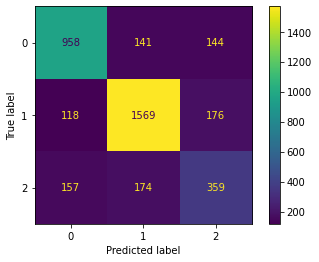

In [51]:
ada_pipe = construct_pipeline(AdaBoostClassifier(base_estimator=svm, algorithm='SAMME'), preprocess_pipe)
param_grid = {'clf__n_estimators': (125, 150, 200, 225, 250),
             'clf__learning_rate': (1e-3, 1e-2, 1e-1, 1)}
tuned_ada = tune_model(ada_pipe, param_grid, X_train, y_train)

### Gradient boosting

-------------------Metrics on training set --------------------------
F1 score on training set:  0.8257575757575757

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       991
           1       0.82      0.95      0.88      1491
           2       0.72      0.52      0.60       554

    accuracy                           0.83      3036
   macro avg       0.81      0.76      0.78      3036
weighted avg       0.82      0.83      0.82      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7381578947368422

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       252
           1       0.77      0.88      0.83       372
           2       0.52      0.32      0.40       136

    accuracy                           0.74       760
   macro avg       0.68      0.65      0.66       760
weighted avg       0.72      0.74      0.72       760



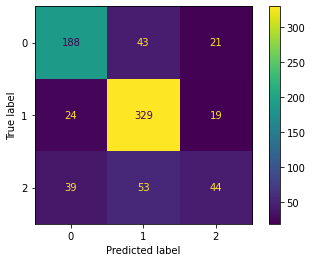

In [52]:
gradboost = train_model(GradientBoostingClassifier(), preprocess_pipe, X_train, y_train)

Best parameters:  {'clf__learning_rate': 0.1, 'clf__n_estimators': 100}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.822 +/- 0.002550
Score of the model on the test set:
0.739 +/- 0.007252
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1243
           1       0.81      0.95      0.88      1863
           2       0.70      0.47      0.56       690

    accuracy                           0.81      3796
   macro avg       0.79      0.74      0.76      3796
weighted avg       0.81      0.81      0.80      3796

------------------------------------------------------------------


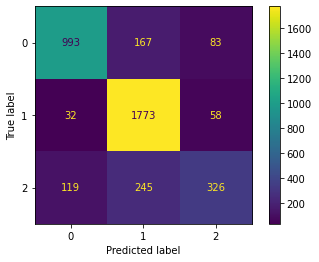

In [53]:
grad_pipe = construct_pipeline(GradientBoostingClassifier(), preprocess_pipe)
param_grid = {'clf__n_estimators': (50, 100, 150, 200),
             'clf__learning_rate': (1e-3, 1e-2, 1e-1, 1)}
tuned_grad = tune_model(grad_pipe, param_grid, X_train, y_train)

### Stacking Classifier

-------------------Metrics on training set --------------------------
F1 score on training set:  0.9746376811594203

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       991
           1       0.96      1.00      0.98      1491
           2       1.00      0.97      0.98       554

    accuracy                           0.97      3036
   macro avg       0.98      0.97      0.98      3036
weighted avg       0.98      0.97      0.97      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7421052631578947

              precision    recall  f1-score   support

           0       0.75      0.78      0.77       252
           1       0.78      0.86      0.82       372
           2       0.54      0.35      0.42       136

    accuracy                           0.74       760
   macro avg       0.69      0.66      0.67       760
weighted avg       0.73      0.74      0.73       760



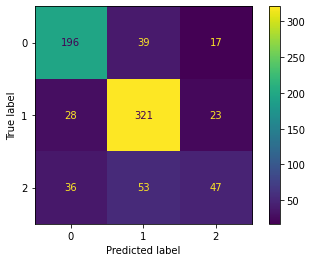

In [54]:
logreg_pipe = construct_pipeline(LogisticRegression(C = 1, penalty= 'elasticnet', l1_ratio = 0.5, solver='saga', max_iter=2000), preprocess_pipe)
rf_pipe = construct_pipeline(RandomForestClassifier(n_estimators = 175), preprocess_pipe)
gradboost_pipe = construct_pipeline(GradientBoostingClassifier(n_estimators = 150, learning_rate=0.1), preprocess_pipe)
estimators = [('log', logreg_pipe),
             ('rf', rf_pipe),
             ('grad', gradboost_pipe)]
stack_clf = train_model(StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()), None, X_train, y_train)

## Feature selection

After preprocessing, there are 691 features. This high dimensionality might be affecting the performance of the models. So let's try decreasing the number of features.

#### On Decision trees

We use ~SelectKBest~, ~RFE~ strategies for feature selection.

-------------------Metrics on training set --------------------------
F1 score on training set:  0.7523056653491436

              precision    recall  f1-score   support

           0       0.87      0.68      0.76       991
           1       0.73      0.95      0.83      1491
           2       0.58      0.34      0.43       554

    accuracy                           0.75      3036
   macro avg       0.73      0.66      0.67      3036
weighted avg       0.75      0.75      0.73      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7223684210526314

              precision    recall  f1-score   support

           0       0.82      0.68      0.74       252
           1       0.73      0.90      0.81       372
           2       0.46      0.30      0.36       136

    accuracy                           0.72       760
   macro avg       0.67      0.63      0.64       760
weighted avg       0.71      0.72      0.71       760



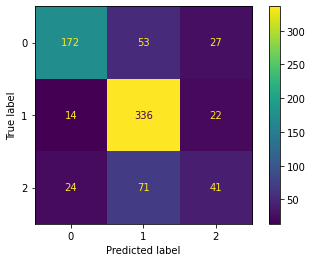

In [55]:

feature_selector = SelectKBest(k=60)
pipe = Pipeline([('preprocessing', preprocess_pipe),
                ('selector', feature_selector),
                ('dtree', DecisionTreeClassifier(max_depth=5, ccp_alpha=0.001))])

clf = train_model(pipe, None, X_train, y_train)

Best parameters:  {'selector__k': 20}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.741 +/- 0.006246
Score of the model on the test set:
0.723 +/- 0.007041
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1243
           1       0.73      0.94      0.82      1863
           2       0.58      0.29      0.39       690

    accuracy                           0.74      3796
   macro avg       0.71      0.64      0.65      3796
weighted avg       0.73      0.74      0.72      3796

------------------------------------------------------------------


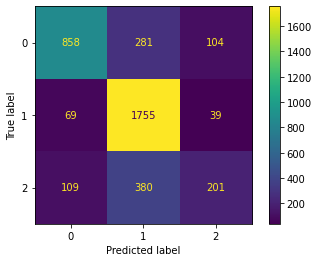

In [56]:
pipe = Pipeline([('preprocessing', preprocess_pipe),
                ('selector', feature_selector),
                ('dtree', DecisionTreeClassifier(max_depth=5, ccp_alpha=0.001))])
param_grid = {'selector__k': range(10, 110, 10)}
tuned_clf = tune_model(pipe, param_grid, X_train, y_train)

-------------------Metrics on training set --------------------------
F1 score on training set:  0.7091567852437418

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       991
           1       0.72      0.91      0.81      1491
           2       0.49      0.28      0.36       554

    accuracy                           0.71      3036
   macro avg       0.66      0.61      0.62      3036
weighted avg       0.69      0.71      0.69      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.6776315789473685

              precision    recall  f1-score   support

           0       0.74      0.59      0.66       252
           1       0.71      0.90      0.80       372
           2       0.36      0.24      0.28       136

    accuracy                           0.68       760
   macro avg       0.60      0.57      0.58       760
weighted avg       0.66      0.68      0.66       760



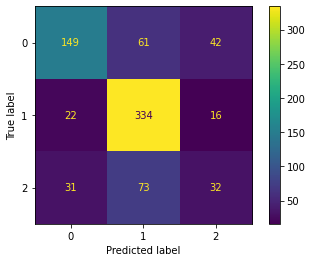

In [57]:
feature_selector = SequentialFeatureSelector(RidgeClassifier(alpha=10), n_features_to_select=20)
pipe = Pipeline([('preprocessing', preprocess_pipe),
                    ('selector', feature_selector)])

clf = train_model(DecisionTreeClassifier(max_depth=5, ccp_alpha=0.001), pipe, X_train, y_train)

-------------------Metrics on training set --------------------------
F1 score on training set:  0.9953886693017128

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       0.99      1.00      1.00      1491
           2       0.99      0.99      0.99       554

    accuracy                           1.00      3036
   macro avg       1.00      0.99      0.99      3036
weighted avg       1.00      1.00      1.00      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7368421052631579

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       252
           1       0.76      0.88      0.82       372
           2       0.52      0.32      0.39       136

    accuracy                           0.74       760
   macro avg       0.68      0.65      0.66       760
weighted avg       0.72      0.74      0.72       760



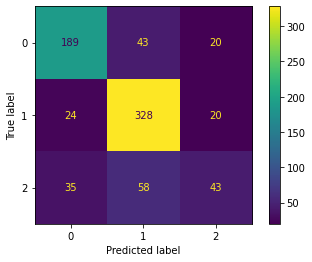

In [58]:
rfe = RFE(LogisticRegression(max_iter=5000, solver='saga', random_state=42), step=1)
pipe = Pipeline([('rfe', rfe),
                ('model', RandomForestClassifier())])
clf = train_model(pipe, None, X_train, y_train)

Best parameters:  {'model__n_estimators': 150, 'rfe__n_features_to_select': 200}
-------------------Best model performance --------------------------
Score of the model on the train set:
1.000 +/- 0.000000
Score of the model on the test set:
0.743 +/- 0.008110
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1243
           1       1.00      1.00      1.00      1863
           2       1.00      1.00      1.00       690

    accuracy                           1.00      3796
   macro avg       1.00      1.00      1.00      3796
weighted avg       1.00      1.00      1.00      3796

------------------------------------------------------------------


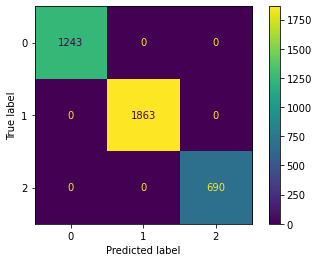

In [59]:
param_grid = {'rfe__n_features_to_select': [50, 100, 150, 200],
             'model__n_estimators': [100, 150, 200, 250, 300]}
tuned_model = tune_model(pipe, param_grid, X_train, y_train)

## Class Imbalance

The class with label 2 is found to be hard to predict, driving down overall performance. Using `class_weight` parameter in all of the above estimators is giving an even worse score. Now let's try to solve the problem with oversampling.

In [60]:
cat_features = ['v_1', 'v_26', 'v_11', 'v_14', 'v_30', 'v_28', 'v_9', 'v_27', 'v_32', 'v_4', 'v_3', 'v_20', 'v_21', 'v_18', 'v_25', 'v_12', 'v_31', 'v_15', 'v_19', 'v_13', 'v_33', 'v_17', 'v_29', 'v_23', 'v_6', 'v_24', 'v_10', 'v_5', 'v_22', 'v_0' ]
num_features = ['v_16', 'v_2', 'v_8', 'v_7', 'v_34', 'v_35', 'v_36', 'v_37', 'v_38', 'v_39', 'v_40']
cat_features_bool = [True if x in cat_features else False for x in X_train.columns]
smote = SMOTENC(categorical_features = cat_features_bool)

### Logistic Regression

-------------------Metrics on training set --------------------------
F1 score on training set:  0.7816205533596838

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       991
           1       0.84      0.84      0.84      1491
           2       0.54      0.64      0.58       554

    accuracy                           0.78      3036
   macro avg       0.75      0.75      0.75      3036
weighted avg       0.79      0.78      0.79      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7026315789473684

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       252
           1       0.80      0.74      0.77       372
           2       0.43      0.55      0.48       136

    accuracy                           0.70       760
   macro avg       0.66      0.67      0.67       760
weighted avg       0.72      0.70      0.71       760



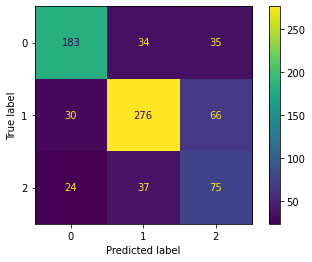

In [61]:
logreg_pipe = imbpipeline([('smote', smote),
                           ('preprocess', preprocess_pipe),
                           ('logreg', LogisticRegression(C=1, penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=2000))])
clf = train_model(logreg_pipe, None, X_train, y_train)

c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters:  {'logreg__C': 1, 'logreg__l1_ratio': 0.9}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.772 +/- 0.007401
Score of the model on the test set:
0.709 +/- 0.019202
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1243
           1       0.84      0.82      0.83      1863
           2       0.52      0.61      0.56       690

    accuracy                           0.77      3796
   macro avg       0.73      0.74      0.73      3796
weighted avg       0.78      0.77      0.77      3796

------------------------------------------------------------------


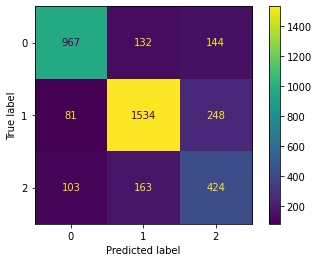

In [62]:
logreg_pipe = imbpipeline([('smote', smote),
                           ('preprocess', preprocess_pipe),
                           ('logreg', LogisticRegression(C=1, penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=2000))])
param_grid = {'logreg__C': ( 0.001, 0.01, 0.1, 1, 10),
             'logreg__l1_ratio': (0, 0.1, 0.3, 0.5, 0.7, 0.9, 1)}
tuned_log_reg = tune_model(logreg_pipe, param_grid, X_train, y_train)

### Decision Tree

-------------------Metrics on training set --------------------------
F1 score on training set:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       1.00      1.00      1.00      1491
           2       1.00      1.00      1.00       554

    accuracy                           1.00      3036
   macro avg       1.00      1.00      1.00      3036
weighted avg       1.00      1.00      1.00      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.6210526315789474

              precision    recall  f1-score   support

           0       0.65      0.64      0.65       252
           1       0.77      0.69      0.73       372
           2       0.30      0.39      0.34       136

    accuracy                           0.62       760
   macro avg       0.57      0.57      0.57       760
weighted avg       0.65      0.62      0.63       760



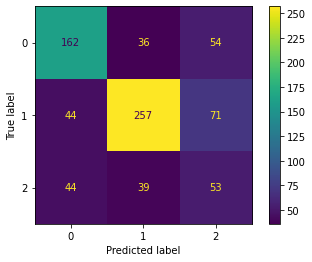

In [63]:
tree_pipe = imbpipeline([('smote', smote),
                        ('dtree', DecisionTreeClassifier())])
clf = train_model(tree_pipe, None, X_train, y_train)

Best parameters:  {'dtree__ccp_alpha': 0.001, 'dtree__max_depth': 8}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.749 +/- 0.004668
Score of the model on the test set:
0.689 +/- 0.016385
              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1243
           1       0.77      0.86      0.81      1863
           2       0.49      0.51      0.50       690

    accuracy                           0.74      3796
   macro avg       0.70      0.68      0.69      3796
weighted avg       0.74      0.74      0.74      3796

------------------------------------------------------------------


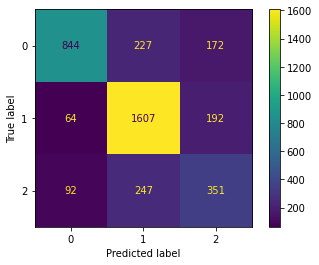

In [64]:
dtree_pipe = imbpipeline([('smote', smote),
                        ('dtree', DecisionTreeClassifier())])
param_grid = {'dtree__max_depth': (2, 3, 4, 5, 6, 7, 8, 9, 10, 15),
              'dtree__ccp_alpha': (1e-4,1e-3, 1e-2, 0.025, 1e-1, 1)}
tuned_dtree = tune_model(dtree_pipe, param_grid, X_train, y_train)

### Random Forest

-------------------Metrics on training set --------------------------
F1 score on training set:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       1.00      1.00      1.00      1491
           2       1.00      1.00      1.00       554

    accuracy                           1.00      3036
   macro avg       1.00      1.00      1.00      3036
weighted avg       1.00      1.00      1.00      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7486842105263158

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       252
           1       0.80      0.86      0.83       372
           2       0.51      0.47      0.49       136

    accuracy                           0.75       760
   macro avg       0.70      0.69      0.69       760
weighted avg       0.74      0.75      0.75       760



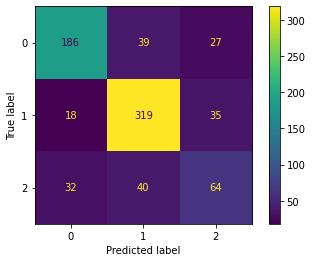

In [65]:
rf_pipe = imbpipeline([('smote', smote),
                        ('rf', RandomForestClassifier())])
clf = train_model(rf_pipe, None, X_train, y_train)

Best parameters:  {'rf__min_samples_split': 4, 'rf__n_estimators': 200}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.997 +/- 0.000484
Score of the model on the test set:
0.737 +/- 0.013935
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1243
           1       0.99      1.00      1.00      1863
           2       1.00      0.99      0.99       690

    accuracy                           1.00      3796
   macro avg       1.00      0.99      1.00      3796
weighted avg       1.00      1.00      1.00      3796

------------------------------------------------------------------


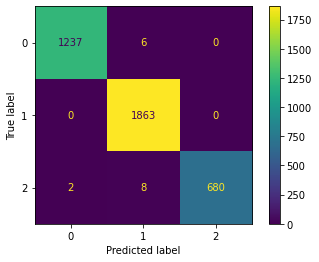

In [66]:
rf_pipe = imbpipeline([('smote', smote),
                        ('rf', RandomForestClassifier())])
param_grid = {'rf__n_estimators': [50, 100, 150, 200],
             'rf__min_samples_split':range(2, 10)}
tuned_rf = tune_model(rf_pipe, param_grid, X_train, y_train)

-------------------Metrics on training set --------------------------
F1 score on training set:  0.8007246376811594

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       991
           1       0.84      0.89      0.86      1491
           2       0.57      0.60      0.59       554

    accuracy                           0.80      3036
   macro avg       0.76      0.76      0.76      3036
weighted avg       0.80      0.80      0.80      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7328947368421054

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       252
           1       0.80      0.83      0.81       372
           2       0.46      0.50      0.48       136

    accuracy                           0.73       760
   macro avg       0.69      0.68      0.68       760
weighted avg       0.74      0.73      0.73       760



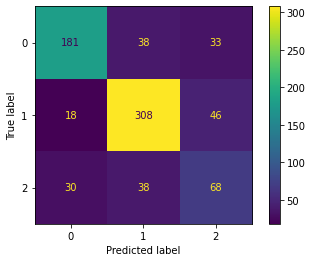

In [67]:
grad_pipe = imbpipeline([('smote', smote),
                         ('pre', preprocess_pipe),
                        ('gradboost', GradientBoostingClassifier())])
gradboost = train_model(grad_pipe, None, X_train, y_train)

Best parameters:  {'model__learning_rate': 0.1, 'model__n_estimators': 200}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.854 +/- 0.005330
Score of the model on the test set:
0.738 +/- 0.014178
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1243
           1       0.87      0.92      0.89      1863
           2       0.66      0.68      0.67       690

    accuracy                           0.84      3796
   macro avg       0.81      0.80      0.81      3796
weighted avg       0.84      0.84      0.84      3796

------------------------------------------------------------------


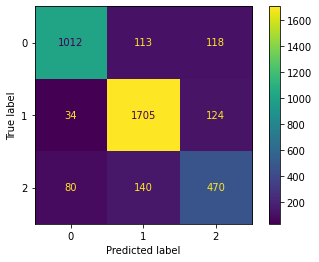

In [68]:
grad_pipe = imbpipeline([('smote', smote),
                         ('pre', preprocess_pipe),
                        ('model', GradientBoostingClassifier())])
param_grid = {'model__n_estimators': (50, 100, 150, 200),
             'model__learning_rate': (1e-3, 1e-2, 1e-1, 1)}
tuned_grad = tune_model(grad_pipe, param_grid, X_train, y_train)

### Multilayer Perceptron

-------------------Metrics on training set --------------------------
F1 score on training set:  0.9548748353096179

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       991
           1       0.97      0.99      0.98      1491
           2       0.91      0.89      0.90       554

    accuracy                           0.95      3036
   macro avg       0.95      0.94      0.94      3036
weighted avg       0.95      0.95      0.95      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.6631578947368421

              precision    recall  f1-score   support

           0       0.69      0.70      0.69       252
           1       0.77      0.74      0.76       372
           2       0.36      0.39      0.37       136

    accuracy                           0.66       760
   macro avg       0.61      0.61      0.61       760
weighted avg       0.67      0.66      0.67       760



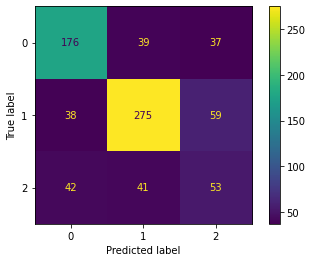

In [69]:
mlp_clf = train_model(MLPClassifier(hidden_layer_sizes=(10,10,10,10), max_iter=1000), preprocess_pipe, X_train, y_train)

## Model Performance Comparison

The following table summarises the result of the above models. The score reported is $F_1$ score(micro averaged).
 
| Model               | Train Score | Test Score |
| ------------------- | ----------- | ---------- |
| KNN                 | 0.623       | 0.604      |
| Ridge classifier    | 0.782       | 0.721      |
| Logistic Regression | 0.806       | 0.736      |
| SoftMax Regression  | 0.806       | 0.736      |
| Linear SVM          | 0.804       | 0.726      |
| Decision Tree       | 0.744       | 0.717      |
| Random Forest       | 0.974       | 0.742      |
| AdaBoost            | 0.742       | 0.72       |
| GradientBoost       | 0.848       | 0.739      |
| Stacking Classifier | 0.975       | 0.749      |

## Final Model

Feature selection and oversampling were not able to improve the models. The best performing model was a stacked classifier constructed by stacking Logistic regression, Random Forest and Gradient boost models together and using Logistic regression as the final estimator.

-------------------Metrics on training set --------------------------
F1 score on training set:  0.941699604743083

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       991
           1       0.93      0.98      0.96      1491
           2       0.96      0.88      0.91       554

    accuracy                           0.94      3036
   macro avg       0.95      0.92      0.93      3036
weighted avg       0.94      0.94      0.94      3036

-------------------Metrics on test set --------------------------
F1 score on test set:  0.7421052631578947

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       252
           1       0.77      0.86      0.82       372
           2       0.54      0.36      0.43       136

    accuracy                           0.74       760
   macro avg       0.69      0.66      0.67       760
weighted avg       0.73      0.74      0.73       760



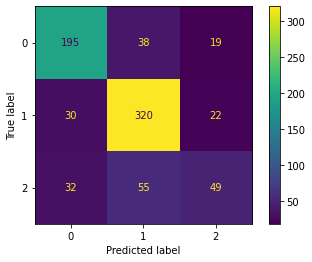

In [70]:
logreg_pipe = construct_pipeline(LogisticRegression(C = 1, penalty= 'elasticnet', l1_ratio = 0.5, solver='saga', max_iter=2000), preprocess_pipe)
rf_pipe = construct_pipeline(RandomForestClassifier(n_estimators = 300, min_samples_split=6), preprocess_pipe)
gradboost_pipe = construct_pipeline(GradientBoostingClassifier(n_estimators = 150, learning_rate=0.1), preprocess_pipe)
estimators = [('log', logreg_pipe),
             ('rf', rf_pipe),
             ('grad', gradboost_pipe)]
             
stack_clf = train_model(StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()), None, X_train, y_train)